In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875
coordinate: [0.91274243 1.71944335] label: 0
coordinate: [0.31320654 1.7697818 ] label: 0
coordinate: [ 1.42367768 -0.71369375] label: 1
coordinate: [-0.06637929  2.15324284] label: 0
coordinate: [1.03633188 0.65861141] label: 1
coordinate: [ 4.00654918 -0.68307969] label: 1
coordinate: [ 1.72505491 -0.40304943] label: 1
coordinate: [3.05388838 0.64528482] label: 1
coordinate: [ 0.34308874 -1.32592215] label: 2
coordinate: [1.72502646 0.69204534] label: 1
coordinate: [ 0.39245338 -1.66365824] label: 2
coordinate: [0.51469554 1.20611391] label: 0
coordinate: [ 0.34445267 -1.51628726] label: 2
coordinate: [ 0.29852545 -1.58566581] label: 2
coordinate: [ 0.57887005 -1.2525927 ] label: 2
coordinate: [-0.37701377  2.2956363 ] label: 0
coordinate: [0.84707321 1.07075904] label: 0
coordinate: [0.33462706

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


coordinate: [ 2.55999626 -0.25544035] label: 1
coordinate: [ 1.14637149 -0.62829782] label: 1
coordinate: [ 1.1329626  -1.32779576] label: 2
coordinate: [0.10989276 1.72644047] label: 0
coordinate: [-0.96430773  1.75133046] label: 0
coordinate: [0.4015209  0.80978884] label: 0
coordinate: [ 1.98730972 -0.55183216] label: 1
coordinate: [ 2.18031794 -0.01265647] label: 1
coordinate: [1.13453501 1.26993497] label: 0
coordinate: [-0.44388798 -2.03516381] label: 2
coordinate: [-1.34319351  1.74526735] label: 0
coordinate: [ 1.08599814 -0.83309818] label: 2
coordinate: [ 1.57627899 -0.03765476] label: 1
coordinate: [ 0.3673568 -1.1907024] label: 2
coordinate: [0.27800766 1.21584676] label: 0
coordinate: [ 2.17369732 -0.13610612] label: 1
coordinate: [ 1.22861532 -0.87116556] label: 2
coordinate: [2.49589925 0.27575899] label: 1
coordinate: [ 1.34776833 -0.97114284] label: 2
coordinate: [ 0.58586731 -1.19087111] label: 2
coordinate: [ 0.33334516 -1.68816444] label: 2
coordinate: [2.3940851  0

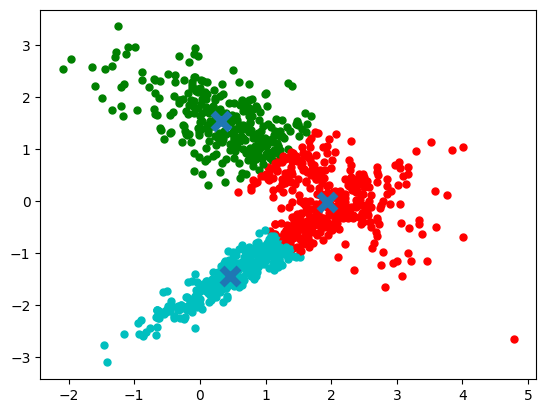

In [10]:
#K-means

# read a txt file
data = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to data todataframe
df = pd.DataFrame(data)

# show the first 5 rows
print(df.head())

X = df.values

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

colors = ["g.","r.","c.","y.","m."]

for i in range(len(X)):
    print("coordinate:",X[i], "label:", labels[i])
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 10)

plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

